In [9]:

import pandas as pd
import pybaseball
pybaseball.cache.enable()
print(pd.__version__)
from pybaseball import statcast
balldata = statcast(start_dt='2025-01-01',end_dt='2025-07-24')
balldata = pd.DataFrame(balldata)
from sklearn.model_selection import train_test_split as tts
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import numpy as np

2.3.1
This is a large query, it may take a moment to complete
Skipping offseason dates


100%|██████████| 132/132 [00:03<00:00, 41.40it/s]
/sciclone/home/tdfelton/.conda/envs/baseball2/lib/python3.11/site-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


In [10]:
balldata = pd.DataFrame(balldata)
balldata = balldata[balldata['game_type'] == 'R']
balldata.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
2548,SI,2025-07-23,83.5,-3.61,1.37,"Rogers, Tyler",686948,643511,field_out,hit_into_play,...,<NA>,4.03,0.13,-0.13,<NA>,-15.27946,19.065945,42.083731,21.13013,22.616788
2681,SI,2025-07-23,84.9,-3.84,1.42,"Rogers, Tyler",686948,643511,None,ball,...,<NA>,3.92,0.12,-0.12,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2764,SL,2025-07-23,74.6,-3.87,1.38,"Rogers, Tyler",686948,643511,None,swinging_strike,...,<NA>,3.32,-0.57,0.57,<NA>,-2.349464,47.133901,22.419802,39.541169,10.095727
2862,SI,2025-07-23,84.1,-3.7,1.45,"Rogers, Tyler",686948,643511,None,called_strike,...,<NA>,3.89,0.21,-0.21,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2883,SI,2025-07-23,83.5,-3.68,1.37,"Rogers, Tyler",621566,643511,field_out,hit_into_play,...,<NA>,4.05,0.16,-0.16,<NA>,-1.201536,11.960876,36.163226,38.448058,27.27669


In [11]:
populated_columns = balldata.columns[balldata.notna().any()].tolist()
balldata = balldata[populated_columns]
# Keep only rows where 'des' does NOT contain 'James Wood'
wood = balldata[balldata['des'].astype(str).str.contains("James Wood", case=False, na=False)]
wood = pd.DataFrame(wood)
wood.shape

(3403, 110)

Dropping the columns that don't have anything to do with batting average or are redundant or outdated
This means any variables that occur after the fact, hit type, description etc
Also dropped variables that happen semi randomly throughout the game like runners on base, the score, things that if you
are given an entire season will occur many times. Simulating batting average against a specific pitcher has to encompass all types of game situation, like innings, runners on, outs, stuff like that.

In [12]:
hits = ['single','double','triple','home_run']
lineups_y = balldata['events'].isin(hits).astype(int)
lineups_y.describe()
lineups_x = balldata.drop(columns=['events'])
lineups_x = lineups_x.drop(
    columns=[col for col in lineups_x.columns if 'depreciated' in col or 'legacy' in col or 'estimated' in col]
)

# Drop specific additional columns
cols_to_drop = [
    'type', 'player_name', 'des', 'home_team', 'game_year', 'away_team', 'game_type',
    'woba_value', 'woba_denom', 'babip_value', 'iso_value', 'launch_speed_angle',
    'post_away_score', 'post_home_score', 'post_bat_score', 'post_fld_score','bat_win_dif'
    'delta_home_win_exp', 'delta_run_exp', 'delta_pitcher_run_exp','bat_score','fld_score',
    'home_score_diff', 'home_win_exp', 'on_3b', 'on_2b', 'on_1b','pitch_name','home_score','away_score','description',
    'hit_location','bb_type','hc_x','hc_y','hit_distance_sc','launch_speed','launch_angle','delta_home_win_exp'
]
lineups_x = lineups_x.drop(columns=[col for col in cols_to_drop if col in lineups_x.columns])
print(lineups_x.shape,lineups_y.shape)
lineups_x.head()

(447150, 67) (447150,)


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,batter,pitcher,zone,stand,p_throws,...,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
2548,SI,2025-07-23,83.5,-3.61,1.37,686948,643511,14,L,R,...,<NA>,4.03,0.13,-0.13,<NA>,-15.27946,19.065945,42.083731,21.13013,22.616788
2681,SI,2025-07-23,84.9,-3.84,1.42,686948,643511,12,L,R,...,<NA>,3.92,0.12,-0.12,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2764,SL,2025-07-23,74.6,-3.87,1.38,686948,643511,11,L,R,...,<NA>,3.32,-0.57,0.57,<NA>,-2.349464,47.133901,22.419802,39.541169,10.095727
2862,SI,2025-07-23,84.1,-3.7,1.45,686948,643511,2,L,R,...,<NA>,3.89,0.21,-0.21,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2883,SI,2025-07-23,83.5,-3.68,1.37,621566,643511,8,L,R,...,<NA>,4.05,0.16,-0.16,<NA>,-1.201536,11.960876,36.163226,38.448058,27.27669


Split the date column into separate variables for improved accuracy

In [13]:
lineups_x['game_year'] = pd.to_datetime(lineups_x['game_date']).dt.year
lineups_x['game_month'] = pd.to_datetime(lineups_x['game_date']).dt.month
lineups_x['game_day'] = pd.to_datetime(lineups_x['game_date']).dt.day
# Then drop the original datetime column
lineups_x = lineups_x.drop(columns=['game_date','game_day'])


Translated all the categorical columns to strings as to avoid giving too much weight to something like the day (30th) or player ID 8192141 etc

In [15]:
categorical_cols = ['game_year','game_month','pitch_type','batter','pitcher','stand','p_throws',
                    'balls','strikes','inning','inning_topbot','game_pk','fielder_2',
                    'fielder_3','fielder_4','fielder_5','fielder_6','fielder_7','fielder_8','fielder_9','pitch_number',
                    'at_bat_number','if_fielding_alignment','of_fielding_alignment','age_pit','age_bat','n_thruorder_pitcher',
                    'n_priorpa_thisgame_player_at_bat','pitcher_days_since_prev_game','batter_days_since_prev_game',
                    'pitcher_days_until_next_game','batter_days_until_next_game']
# See which categorical columns are missing from the DataFrame


lineups_x[categorical_cols] = lineups_x[categorical_cols].astype(str)

In [16]:
x_feat_train, x_feat_test, y_feat_train, y_feat_test = tts(lineups_x, lineups_y, test_size = 0.2)
model = CatBoostClassifier(verbose=100)
model.fit(x_feat_train,y_feat_train,cat_features=categorical_cols)

Learning rate set to 0.126852
0:	learn: 0.4804787	total: 144ms	remaining: 2m 23s
100:	learn: 0.1072325	total: 10.2s	remaining: 1m 30s
200:	learn: 0.0990410	total: 20.6s	remaining: 1m 21s
300:	learn: 0.0950157	total: 30.8s	remaining: 1m 11s
400:	learn: 0.0915192	total: 41.1s	remaining: 1m 1s
500:	learn: 0.0889815	total: 51.4s	remaining: 51.2s
600:	learn: 0.0864893	total: 1m	remaining: 40.5s
700:	learn: 0.0847541	total: 1m 10s	remaining: 30.2s
800:	learn: 0.0831118	total: 1m 20s	remaining: 20.1s
900:	learn: 0.0811922	total: 1m 30s	remaining: 9.99s
999:	learn: 0.0796336	total: 1m 40s	remaining: 0us


Next the goal is to find the most important features to predicting batting average

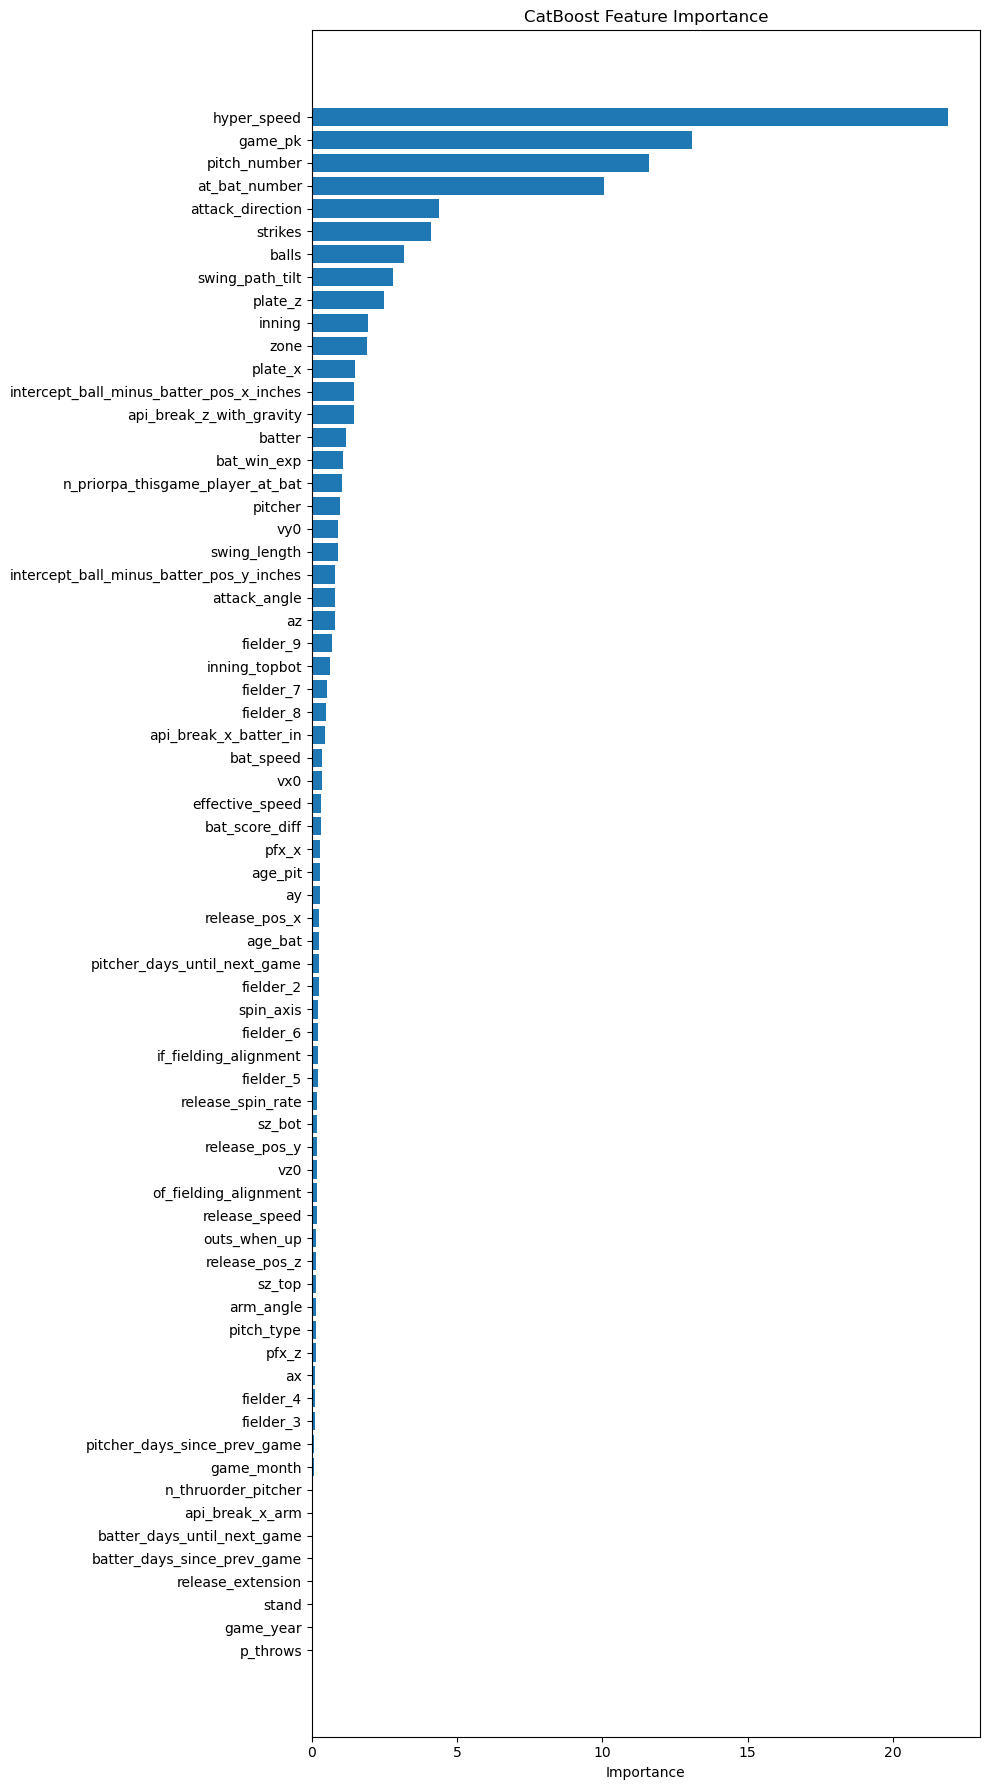

In [17]:
importances = model.get_feature_importance()
features = x_feat_train.columns

# Sort and plot
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 18))
plt.barh(np.array(features)[indices], np.array(importances)[indices])
plt.xlabel("Importance")
plt.title("CatBoost Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

I can't find anything online to figure out what hyper_speed is but it seems to be important
Pretty sure p_throws effects batting average so I will include it in a more refined data pass, same with stand
of_fielding_alignment probably hsa something to do with BA too...
Not sure if this model was the best choice, going to try to run one on a specific batter.
James Wood is my favorite hitter so I will attempt him next.
Current idea is to cross reference the two feature importances and see what happens, hopefully something that makes more sense than this

In [44]:
james_wood = balldata[balldata['des'].astype(str).str.contains("James Wood", case=False, na=False)]
james_wood = pd.DataFrame(wood)
james_wood.shape

(3403, 110)

In [45]:
hits = ['single','double','triple','home_run']
wood_y = james_wood['events'].isin(hits).astype(int)
wood_x = james_wood.drop(columns=['events'])
wood_x = wood_x.drop(
    columns=[col for col in wood_x.columns if 'depreciated' in col or 'legacy' in col or 'estimated' in col]
)

# Drop specific additional columns
cols_to_drop = [
    'type', 'player_name', 'des', 'home_team', 'game_year', 'away_team', 'game_type',
    'woba_value', 'woba_denom', 'babip_value', 'iso_value', 'launch_speed_angle',
    'post_away_score', 'post_home_score', 'post_bat_score', 'post_fld_score','bat_win_dif'
    'delta_home_win_exp', 'delta_run_exp', 'delta_pitcher_run_exp','bat_score','fld_score',
    'home_score_diff', 'home_win_exp', 'on_3b', 'on_2b', 'on_1b','pitch_name','home_score','away_score','description',
    'hit_location','bb_type','hc_x','hc_y','hit_distance_sc','launch_speed','launch_angle','delta_home_win_exp'
]
wood_x = wood_x.drop(columns=[col for col in cols_to_drop if col in wood_x.columns])
print(wood_x.shape,wood_y.shape)
wood_x.head()

(3403, 67) (3403,)


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,batter,pitcher,zone,stand,p_throws,...,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
19,CU,2025-07-23,82.3,3.52,5.51,695578,666157,13,L,L,...,<NA>,3.06,-0.8,-0.8,<NA>,26.398117,-10.901361,43.526849,44.073135,45.802377
24,CU,2025-07-23,81.9,3.49,5.54,695578,666157,13,L,L,...,<NA>,3.15,-0.83,-0.83,<NA>,29.670511,-12.867122,38.956494,58.663642,42.498326
26,CU,2025-07-23,81.5,3.73,5.59,695578,666157,6,L,L,...,<NA>,3.26,-0.69,-0.69,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2748,SL,2025-07-23,83.5,-1.54,6.41,669720,691251,9,R,R,...,<NA>,3.11,-0.32,-0.32,<NA>,15.327239,-2.739369,28.925831,40.229664,38.832984
2827,SL,2025-07-23,86.8,-1.49,6.33,669720,691251,14,R,R,...,<NA>,2.78,-0.14,-0.14,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [46]:
wood_x['game_year'] = pd.to_datetime(wood_x['game_date']).dt.year
wood_x['game_month'] = pd.to_datetime(wood_x['game_date']).dt.month
wood_x['game_day'] = pd.to_datetime(wood_x['game_date']).dt.day
# Then drop the original datetime column



In [47]:
categorical_cols = ['game_month','pitch_type','batter','pitcher','stand','p_throws',
                    'balls','strikes','inning','inning_topbot','game_pk','fielder_2',
                    'fielder_3','fielder_4','fielder_5','fielder_6','fielder_7','fielder_8','fielder_9','pitch_number',
                    'at_bat_number','if_fielding_alignment','of_fielding_alignment','age_pit','age_bat','n_thruorder_pitcher',
                    'n_priorpa_thisgame_player_at_bat','pitcher_days_since_prev_game','batter_days_since_prev_game',
                    'pitcher_days_until_next_game','batter_days_until_next_game']
# See which categorical columns are missing from the DataFrame


wood_x[categorical_cols] = wood_x[categorical_cols].astype(str)

In [48]:
x_wood_train, x_wood_test, y_wood_train, y_wood_test = tts(wood_x, wood_y, test_size = 0.2)
wood_model = CatBoostClassifier(verbose=100)
wood_model.fit(x_wood_train,y_wood_train,cat_features=categorical_cols)

Learning rate set to 0.015799
0:	learn: 0.6711836	total: 6.76ms	remaining: 6.75s
100:	learn: 0.1687716	total: 1.42s	remaining: 12.7s
200:	learn: 0.1362059	total: 2.95s	remaining: 11.7s
300:	learn: 0.1204504	total: 4.48s	remaining: 10.4s
400:	learn: 0.1073529	total: 5.97s	remaining: 8.92s
500:	learn: 0.0950816	total: 7.53s	remaining: 7.5s
600:	learn: 0.0835011	total: 9.11s	remaining: 6.05s
700:	learn: 0.0733052	total: 10.7s	remaining: 4.56s
800:	learn: 0.0655632	total: 12.3s	remaining: 3.05s
900:	learn: 0.0593374	total: 13.9s	remaining: 1.52s
999:	learn: 0.0528794	total: 15.4s	remaining: 0us


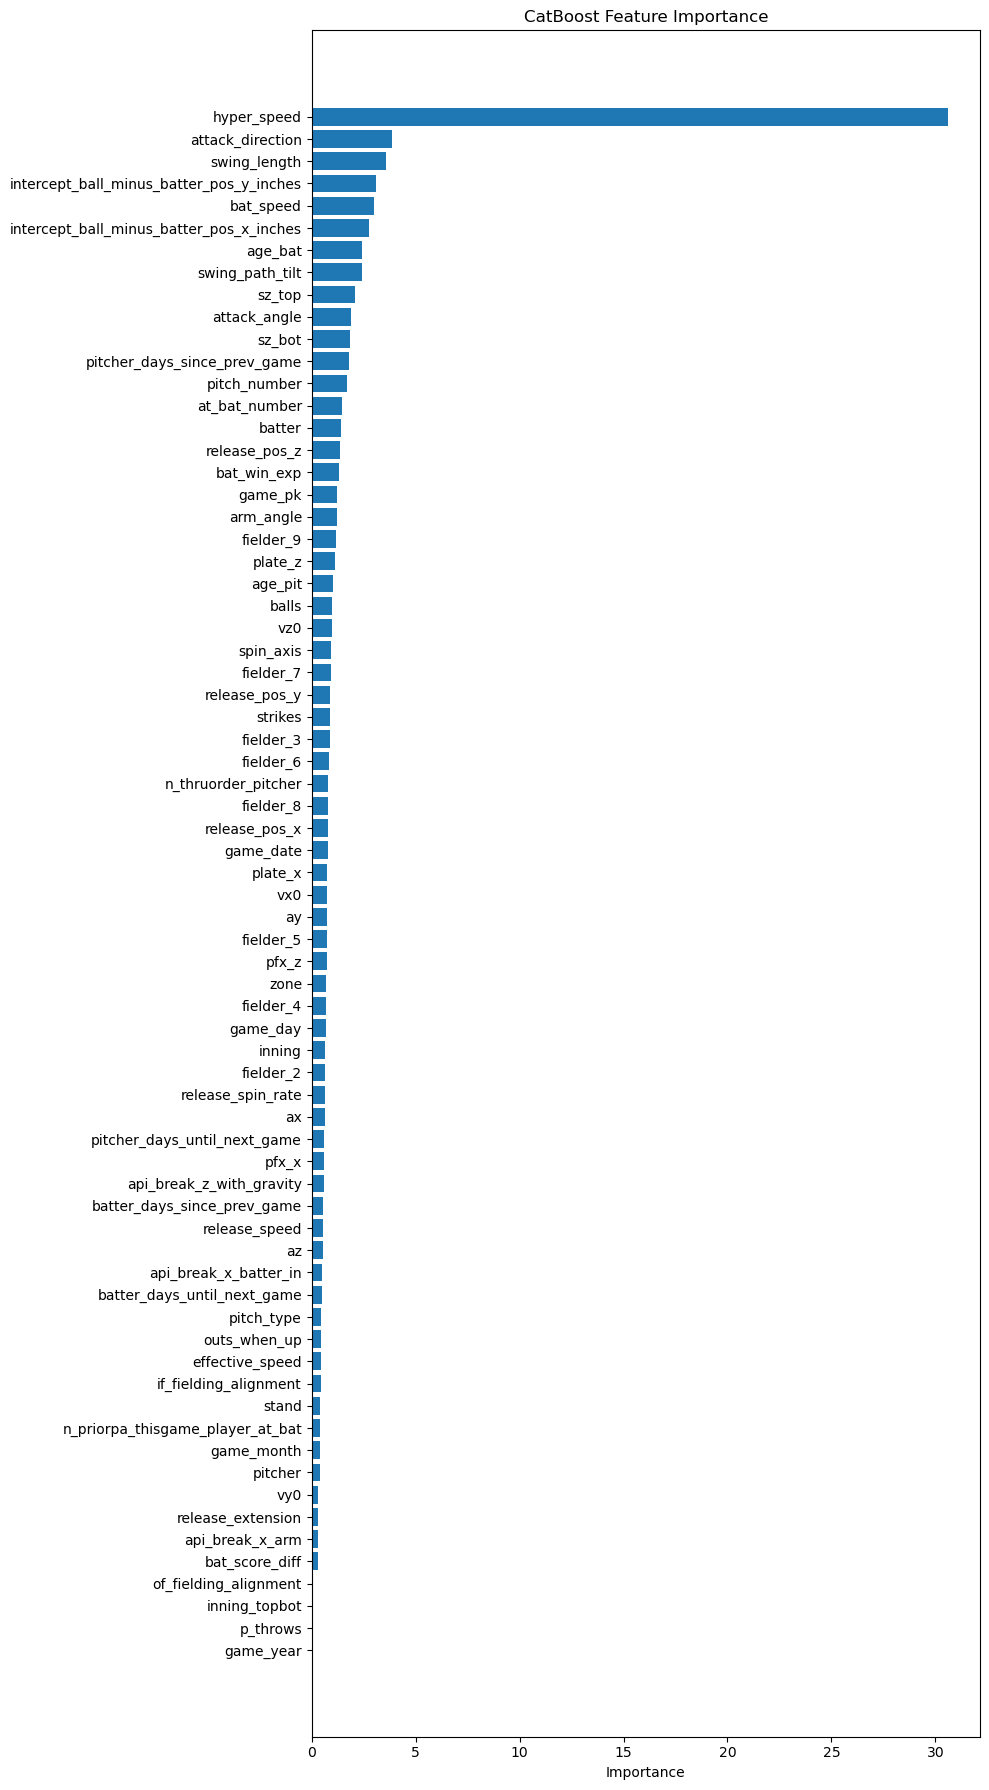

In [49]:
importances = wood_model.get_feature_importance()
features = x_wood_train.columns

# Sort and plot
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 18))
plt.barh(np.array(features)[indices], np.array(importances)[indices])
plt.xlabel("Importance")
plt.title("CatBoost Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

This makes no sense, except.... I still don't know what hyper_speed is! 
Considering dropping it because I think it's results based instead of prepitch/pitch location/ movement etc

I'm going to run this on a few more players with/without hyperspeed and see what the trends are. 

Training the model batter by batter is probably the right approach imo because every hitter has their own unique approach to hitting like swing path speed hotzones etc